# Simulating a Card Game: 6 nimmt

## Game Rules

1. Game Setup

   - Players: Each game can have between 2 to 10 players.
   - Deck: Consists of 104 cards numbered 1 to 104.
   - Initial Setup: Each player is dealt 10 cards, and four cards are placed face-up to start four rows.

2. Game Flow

   - Round: Players simultaneously select a card to play.
   - Card Placement: Cards are placed in rows according to game rules.
   - Penalties: Players collect cards if they have to place the sixth card in a row.

3. Ending the Game

   - The game ends after 10 rounds. The player with the fewest penalty points wins.

## Simulation Framework

In [265]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

debug = True

# Define Player class
class Player:
    def __init__(self, strategy, player_id):
        self.strategy = strategy
        self.hand = []
        self.penalty_points = 0        
        self.penalty_points_history = []
        self.player_id = player_id

    def choose_card(self, game_state):
        return self.strategy(self, game_state)

    def record_penalty_points(self):
        self.penalty_points_history.append(self.penalty_points)

# Define Game class
class Game:
    def __init__(self, strategies):
        self.players = [Player(strategy, i) for i, strategy in enumerate(strategies)]
        self.deck = []
        self.rows = []

    def setup(self):
        self.deck = list(range(1, 105))
        np.random.shuffle(self.deck)
        self.rows = []
        for player in self.players:
            player.hand = sorted([self.deck.pop() for _ in range(10)])
        self.rows = [[self.deck.pop()] for _ in range(4)]  # Initialize four rows with one card each
        
    def get_bullheads(self, card):
        if card % 55 == 0:
            return 7
        elif card % 11 == 0:
            return 5
        elif card % 10 == 0:
            return 3
        elif card % 5 == 0:
            return 2
        else:
            return 1

    def play_step(self):
        # Each player chooses a card to play
        chosen_cards = [(player.choose_card(self.rows), player) for player in self.players]
        chosen_cards.sort()  # Sort cards to determine play order
        
        if (debug): 
            print("Chosen cards:", [(card, player.player_id) for card, player in chosen_cards])

        for card, player in chosen_cards:
            row_choice = None
            min_difference = float('inf')
            
            # Find the best row to place the card
            for row in self.rows:
                if row[-1] < card:
                    difference = card - row[-1]
                    if difference < min_difference:
                        min_difference = difference
                        row_choice = row
            
            if row_choice is None:
                # Card can't be placed in any row, because it is smaller than the last card in any row, so the player must take one row
                if (debug):
                    print("Card can't be placed in any row")
                # Player takes the row with the fewest penalty points
                row_choice = min(self.rows, key=lambda r: sum(self.get_bullheads(c) for c in r))
            
                penalty_points = sum(self.get_bullheads(c) for c in row_choice)
                if (debug):
                    print(f"Player{player.player_id} chooses to take row {row_choice} and incurs {penalty_points} penalty points")
                player.penalty_points += penalty_points
                self.rows.remove(row_choice)
                self.rows.append([card]) # The card starts a new row
            else:
                if (debug):
                    print("Card is is the 6th card in a row")
                row_choice.append(card)
                if len(row_choice) > 5:
                    # Player takes the five cards and incurs penalty points
                    penalty_points = sum(self.get_bullheads(c) for c in row_choice[:-1])
                    if (debug):
                        print(f"Player{player.player_id} must take row {row_choice[:-1]} and incurs {penalty_points} penalty points")
                    player.penalty_points += penalty_points
                    row_choice[:] = [row_choice[-1]]  # Start new row with the last card
                    
            if (debug):
                # Print the state after each card placement
                print(f"After Player{player.player_id} places {card}:")
                for row in self.rows:
                    print(row)
                    
        # Record penalty points after the round
        for player in self.players:
            player.record_penalty_points()
            
    def play_round(self):
        for step_number in range(10):
            if (debug):
                print(f"--- Step {step_number + 1} ---")
            self.play_step()


    def play_game(self):
        round_number = 1
        while True:
            if (debug):
                print(f"------ Round {round_number} -------")
                
            self.setup()
            
            if (debug):
                print("Initial hands:")
                for player in self.players:
                    print(f"Player {player.player_id}: {player.hand}")
                print("Initial rows:", self.rows)
                
            self.play_round()
            
            # Check if any player has collected 66 or more bullheads
            for player in self.players:
                if player.penalty_points >= 66:
                    penalty_points_histories = [player.penalty_points_history for player in self.players]
                    if (debug):
                        print("Final penalty_points_histories:", penalty_points_histories)
                    return penalty_points_histories
            
            round_number += 1


## Strategy Implementation

- Random: Play a random card.
- Lowest First: Play the lowest available card.
- Highest First: Play the highest available card.
- Midrange: Play a card that minimizes the difference with the last card in a row.

In [266]:
# Strategy 1: Random
def random_strategy(player, game_state):
    return player.hand.pop(np.random.randint(len(player.hand)))

# Strategy 2: Lowest First
def lowest_first_strategy(player, game_state):
    return player.hand.pop(0)

# Strategy 3: Highest First
def highest_first_strategy(player, game_state):
    return player.hand.pop(-1)

# Strategy 4: Midrange
def midrange_strategy(player, game_state):
    mid_card = min(player.hand, key=lambda x: abs(x - np.mean([row[-1] for row in game_state])))
    player.hand.remove(mid_card)
    return mid_card

# Strategy 5: Avoid Penalty
def avoid_penalty_strategy(player, game_state):
    # Implement a more sophisticated strategy to avoid penalties
    pass


## Executing Simulation

In [267]:
# Playing a single game for debugging purposes
game = Game([random_strategy, lowest_first_strategy, highest_first_strategy, midrange_strategy])
game.play_game()
result = [player.penalty_points_history for player in game.players]
print(result)

------ Round 1 -------
Initial hands:
Player 0: [5, 7, 10, 13, 18, 21, 37, 77, 90, 96]
Player 1: [16, 17, 22, 39, 43, 59, 65, 69, 95, 103]
Player 2: [8, 26, 35, 40, 71, 72, 79, 83, 85, 102]
Player 3: [9, 11, 14, 29, 31, 44, 66, 73, 78, 91]
Initial rows: [[100], [23], [30], [1]]
--- Step 1 ---
Chosen cards: [(16, 1), (44, 3), (77, 0), (102, 2)]
Card is is the 6th card in a row
After Player1 places 16:
[100]
[23]
[30]
[1, 16]
Card is is the 6th card in a row
After Player3 places 44:
[100]
[23]
[30, 44]
[1, 16]
Card is is the 6th card in a row
After Player0 places 77:
[100]
[23]
[30, 44, 77]
[1, 16]
Card is is the 6th card in a row
After Player2 places 102:
[100, 102]
[23]
[30, 44, 77]
[1, 16]
--- Step 2 ---
Chosen cards: [(7, 0), (17, 1), (66, 3), (85, 2)]
Card can't be placed in any row
Player0 chooses to take row [23] and incurs 1 penalty points
After Player0 places 7:
[100, 102]
[30, 44, 77]
[1, 16]
[7]
Card is is the 6th card in a row
After Player1 places 17:
[100, 102]
[30, 44, 77]


In [268]:
debug = False


def simulate_games(num_games, strategies):
    all_results = []
    for game_index in range(num_games):
        game = Game(strategies)
        one_game_results = game.play_game()
        all_results.append(one_game_results)
    padded_results = pad_results(all_results, get_max_rounds_all_games(all_results))
    return np.array(padded_results)


def get_max_rounds_all_games(results):
    max_rounds_all_games = max(len(player_results) for game_results in results for player_results in game_results)
    return max_rounds_all_games

def pad_results(results, max_rounds_all_games):
    padded_results = []
    for game in results:
        padded_game_results = []
        for player_result in game:
            padded_result = player_result + [-1] * (max_rounds_all_games - len(player_result))
            padded_game_results.append(padded_result)
        padded_results.append(padded_game_results)
    return np.array(padded_results)



## Data Analysis and Visualization

In [269]:
def analyze_results(results, strategy_labels):
    # Initialize lists to store the non-padded results
    non_padded_final_scores = []
    non_padded_results = [] # a list of arrays to handle varying lengths of games

    for game_result in results:
        max_rounds_in_game = np.count_nonzero(game_result[0] != -1)
        non_padded_results.append(game_result[:, :max_rounds_in_game])
        non_padded_final_scores.append(game_result[:, max_rounds_in_game - 1])

    non_padded_final_scores = np.array(non_padded_final_scores)

    # Calculate average penalty points per step across all rounds
    max_steps = max(len(game[0]) for game in non_padded_results)
    step_penalties = {strategy: [[] for _ in range(10)] for strategy in strategy_labels} # for each strategy, a list of lists to store the penalty points for each step

    rounds_counter = 0
    # Extract the penalty points for each step across all rounds in all games
    for game in non_padded_results:
        # Calculate the number of rounds for the current game
        num_rounds = len(game[0]) // 10
        rounds_counter += num_rounds
        for round_idx in range(num_rounds):
            # Extract the penalty points for the current round
            for step_idx in range(10):
                # Calculate the index of the step in the game (since the point history is not divided by rounds)
                step_index = round_idx * 10 + step_idx
                if step_index < len(game[0]):
                    # Add the penalty points to the corresponding step	
                    for strategy_idx, strategy_label in enumerate(strategy_labels):
                        step_penalties[strategy_label][step_idx].append(game[strategy_idx, step_index])

    avg_penalties_per_step_for_each_player = {strategy: np.array([np.mean(step) for step in steps]) for strategy, steps in step_penalties.items()}
    
    # Calculate the average final penalty points for each strategy
    avg_final_penalties = np.mean(non_padded_final_scores, axis=0)

    # Calculate win rates (the strategy with the lowest penalty points wins)
    win_rates = np.sum(non_padded_final_scores == np.min(non_padded_final_scores, axis=1, keepdims=True), axis=0) / non_padded_final_scores.shape[0]

    num_strategies = avg_final_penalties.shape[0]

    plt.figure(figsize=(14, 6))

    # Plot average penalty points per step
    plt.subplot(1, 3, 1)
    for strategy_label in strategy_labels:
        plt.plot(avg_penalties_per_step_for_each_player[strategy_label], label=strategy_label)
    plt.xlabel('Step')
    plt.ylabel('Average Penalty Points')
    plt.legend()
    plt.title('Average Penalty Points per Step')

    # Plot average final penalty points for each strategy
    plt.subplot(1, 3, 2)
    plt.bar(range(num_strategies), avg_final_penalties)
    plt.xticks(range(num_strategies), strategy_labels)
    plt.title('Average Final Penalty Points')
    plt.xlabel('Strategy')
    plt.ylabel('Penalty Points')

    # Plot win rates for each strategy
    plt.subplot(1, 3, 3)
    plt.bar(range(num_strategies), win_rates)
    plt.xticks(range(num_strategies), strategy_labels)
    plt.title('Win Rate')
    plt.xlabel('Strategy')
    plt.ylabel('Win Rate')

    plt.tight_layout()
    plt.show()

Simulating for 3 players...


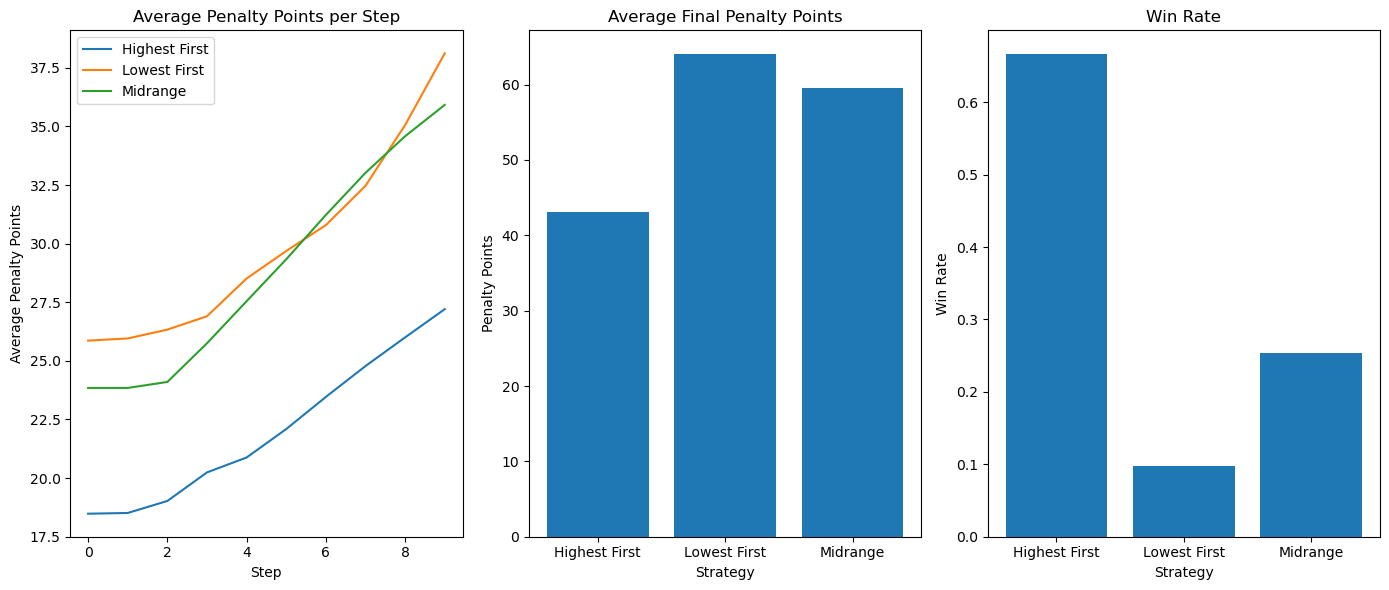

Simulating for 4 players...


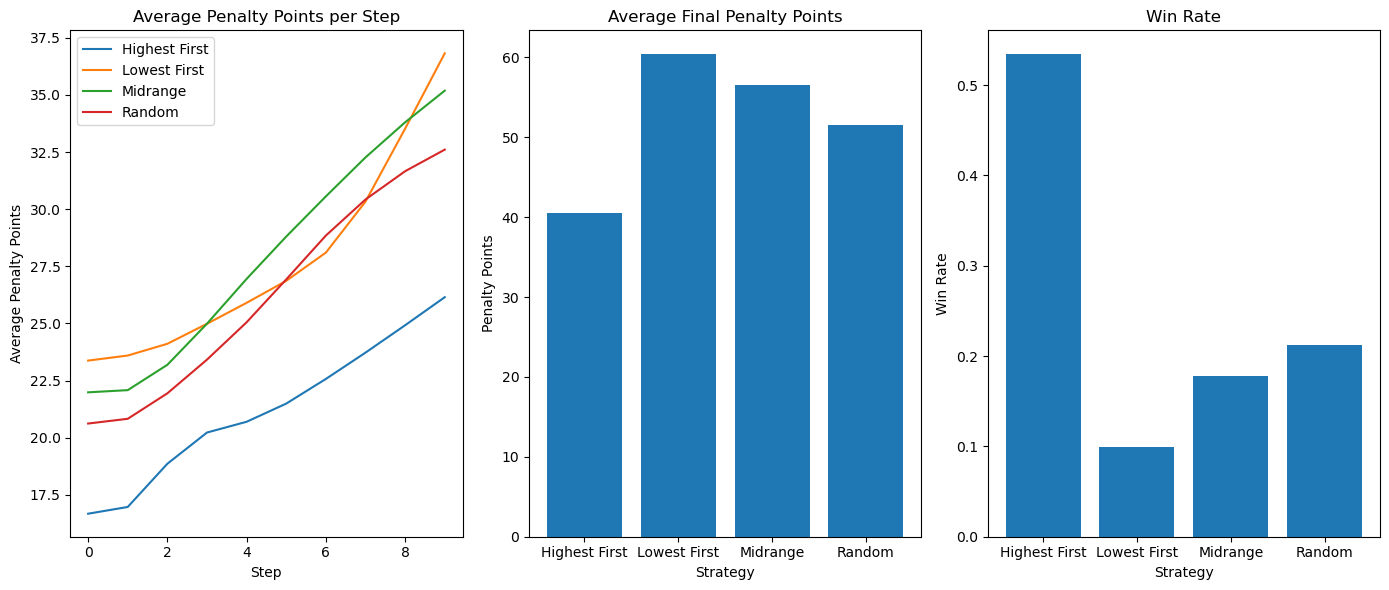

Simulating for 5 players...


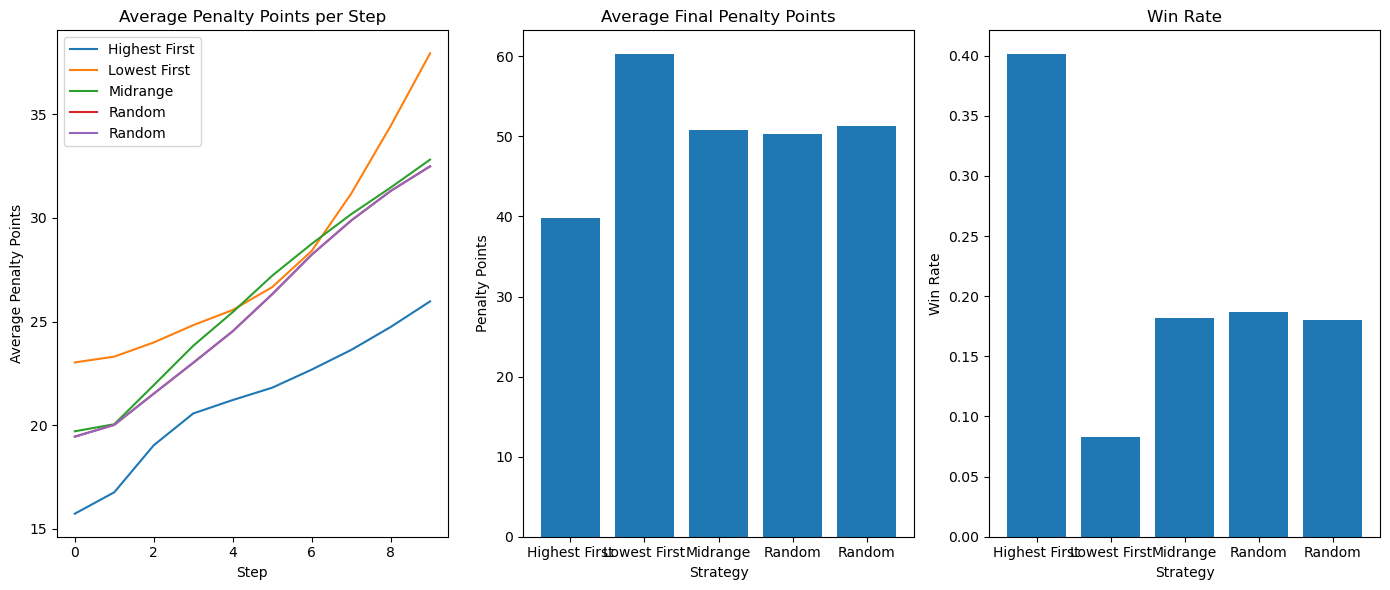

Simulating for 6 players...


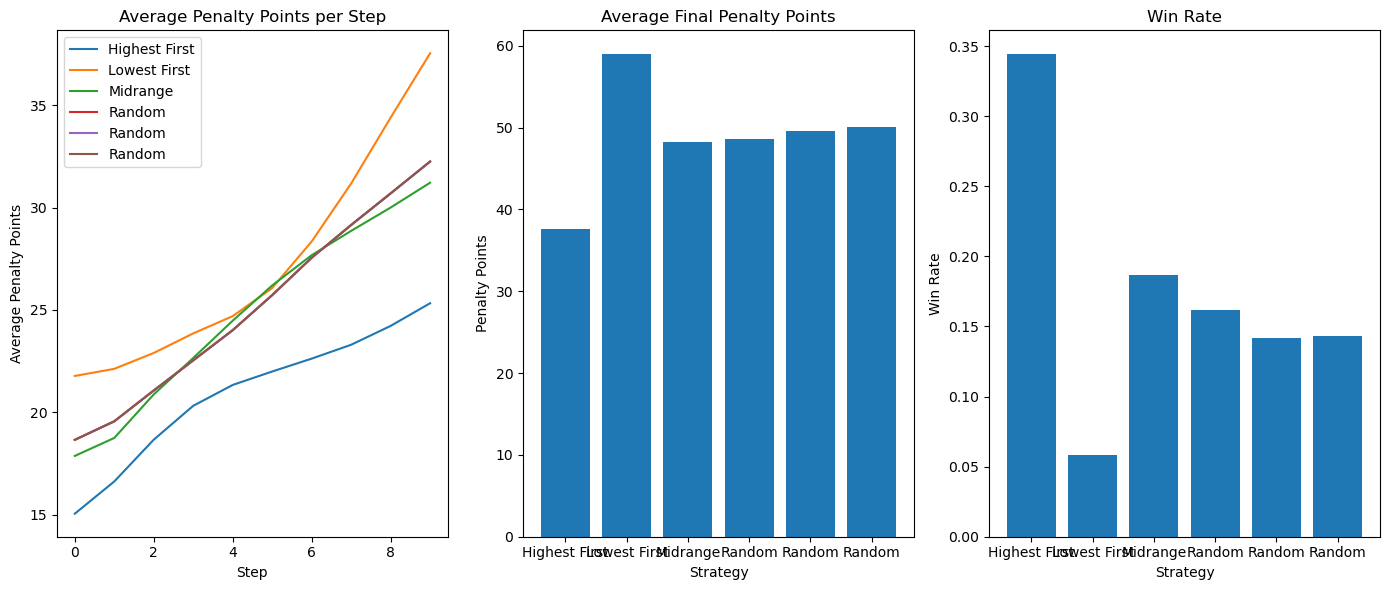

In [270]:
# Simulate and analyze for different numbers of players
num_games = 1000
player_counts = [3, 4, 5, 6]


for num_players in player_counts:
    print(f"Simulating for {num_players} players...")
    strategies = [random_strategy] * num_players
    strategy_labels = ['Random'] * num_players
    strategies[0] = highest_first_strategy	
    strategy_labels[0] = 'Highest First'
    strategies[1] = lowest_first_strategy
    strategy_labels[1] = 'Lowest First'
    strategies[2] = midrange_strategy
    strategy_labels[2] = 'Midrange'
    results = simulate_games(num_games, strategies)
    analyze_results(results, strategy_labels)
    

Simulating for strategy mix 1/8
Simulating for strategy mix 2/8
Simulating for strategy mix 3/8
Simulating for strategy mix 4/8
Simulating for strategy mix 5/8
Simulating for strategy mix 6/8
Simulating for strategy mix 7/8
Simulating for strategy mix 8/8


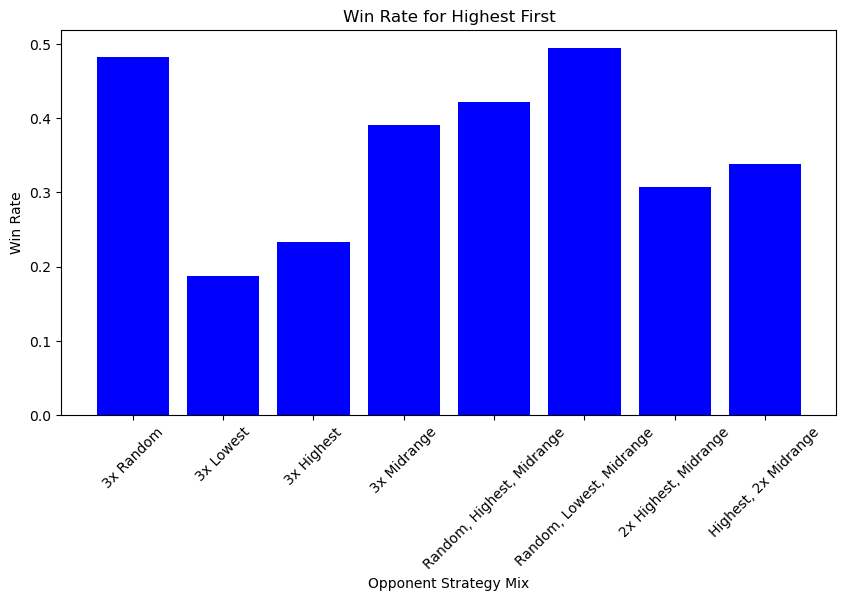

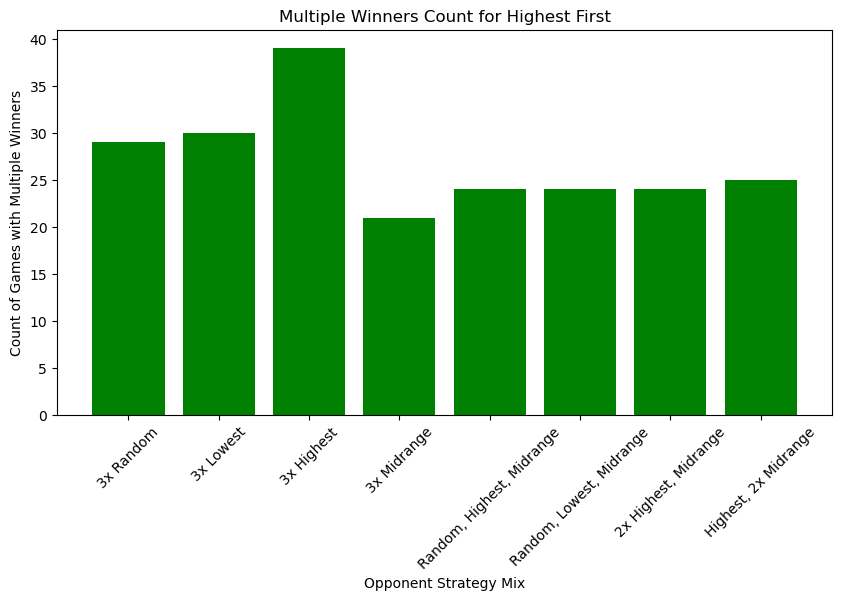

In [272]:
def simulate_strategy_mix(num_games, target_strategy, opponent_combinations):
    results = {}
    for idx, combo in enumerate(opponent_combinations):
        strategy_mix = [target_strategy] + combo
        print(f"Simulating for strategy mix {idx + 1}/{len(opponent_combinations)}")
        combo_games_results = simulate_games(num_games, strategy_mix)
        results[tuple(combo)]=combo_games_results
    return results

def analyze_strategy_mix_results(results, opponent_labels, target_label):
    multiple_winners_counts = {}
    win_rates = {}
    # print(results)
    for combo, game_results in results.items():
        total_games = game_results.shape[0]
        wins = 0
        multiple_winners = 0
        
        for game_result in game_results:
            non_padded_game_results = game_result[:, :np.count_nonzero(game_result[0] != -1)]
            target_strategy_points = non_padded_game_results[0][-1]  # Penalty points of target strategy in the last round
            min_penalty = min(non_padded_game_results[:, -1])  # Minimum penalty points in the last round
            if np.sum(non_padded_game_results[:, -1] == min_penalty) > 1:  # Check if there are multiple winners
                multiple_winners += 1
            elif target_strategy_points == min_penalty:
                wins += 1
                
        multiple_winners_counts[combo] = multiple_winners
        win_rates[combo] = wins / total_games

    # Plot Win Rate
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(win_rates)), list(win_rates.values()), align='center', color='blue')
    plt.xticks(range(len(win_rates)), opponent_labels, rotation=45)
    plt.title(f'Win Rate for {target_label}')
    plt.xlabel('Opponent Strategy Mix')
    plt.ylabel('Win Rate')
    plt.show()

    # Plot Multiple Winners Count
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(multiple_winners_counts)), list(multiple_winners_counts.values()), align='center', color='green')
    plt.xticks(range(len(multiple_winners_counts)), opponent_labels, rotation=45)
    plt.title(f'Multiple Winners Count for {target_label}')
    plt.xlabel('Opponent Strategy Mix')
    plt.ylabel('Count of Games with Multiple Winners')
    plt.show()




# Define the strategies
target_strategy = highest_first_strategy
opponent_combinations = [
    [random_strategy, random_strategy, random_strategy],
    [lowest_first_strategy, lowest_first_strategy, lowest_first_strategy],
    [highest_first_strategy, highest_first_strategy, highest_first_strategy],
    [midrange_strategy, midrange_strategy, midrange_strategy],
    [random_strategy, highest_first_strategy, midrange_strategy],
    [random_strategy, lowest_first_strategy, midrange_strategy],
    [highest_first_strategy, highest_first_strategy, midrange_strategy],
    [highest_first_strategy, midrange_strategy, midrange_strategy]
]
opponent_labels = [
    '3x Random',
    '3x Lowest',
    '3x Highest',
    '3x Midrange',
    'Random, Highest, Midrange',
    'Random, Lowest, Midrange',
    '2x Highest, Midrange',
    'Highest, 2x Midrange'
]

# Simulate and analyze
num_games = 1000
results = simulate_strategy_mix(num_games, target_strategy, opponent_combinations)
analyze_strategy_mix_results(results, opponent_labels, 'Highest First')
